# Using a U-net convolution network for image segmentation
### October 12th 2018
* This notebook goes through the steps of a convolution net model to segment grayscale images.
* It is heavily based on [this tutorial](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) using the "U-net" architecture.
* This method is good for segmenting images when you don't have much training data and is relatively fast. It one some open competitions and the original paper is from 2015. 
* The lab that created the U-net architecture is [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) and they have a video that explains what is going on, though I don't understand all the steps.


## Work flow
1. Use the notebook prepare_image_demo.ipynb to format images in the correct way.
2. [Import our images](#importimages).
    * The images are put into a generator so they are not loaded all at the same time. 
    * The generator will "augment" the images for training, that is, it will transform them in a number of ways to artificially increase the pool of training data to draw from. 
    * The images must be square based on the way they are convolved and split into smaller sections. 
    
    
3. [Build the model](#buildmodel).
    * Set up the covolution, ReLU, max pooling, and other operations that dictate how our images are modified. 
    * The number of layers in the network is dictated by the image size. 
    * We also define our own custom loss functions. The loss function is a measure of how different the predicted labels are from the actual labels. Training means iteritively improving the model to minimize the loss.  
    
    
4. [Train the model](#trainmodel).
    * This step takes awhile. 
    * We will output a graph that plots the loss over training steps.
    
    
5. Use the notebook segment_cells_demo.ipynb to predict masks for images using the model. 

### Import modules

In [12]:
import os
import time
from itertools import izip
import numpy as np

# learning modules
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

# plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (8,8)

<a id='importimages'></a>
# Import images
We will set up our training data generator to do image augmentation, and the validation data generator **not** to do augmentation, which is the default behavior of the `ImageDataGenerator` class. [This blog](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2) describes using generators with Keras nicely. 

In [13]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

# I guess everything defaults to false here. 
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

## Make the image generators

Provide the same seed and keyword arguments to the flow methods for image and mask generators to ensure we get the same data augmentation performed for a given image and its associated mask.

### NOTE:
I had to modify the source code for tensorflow to get 16-bit images to read in correctly. My problem was that the pixel intensity values of all my 16-bit images, after reading in, were truncated to 255! 

Following the suggestion by jfx319 [here](https://github.com/keras-team/keras/issues/4486), I modified tensorflow's image.py code in `load_img` from:

```python
if grayscale:
    if img.mode != 'L':
        img = img.convert('L')
```

to now be:

```python
if grayscale:
    img = img.convert('I')
```

That seems to be a fine fix. If you're not sure where to find tensorflow's image.py, I recommend running the following from your command line:

```bash
locate image.py | grep tensorflow
```

In [14]:
# This can help locate the above function in the file system
# ImageDataGenerator?? 

In [15]:
data_dir = './demo/data'

In [16]:
seed = 1
batch_size = 5
train_image_generator = train_image_datagen.flow_from_directory(
    os.path.join(data_dir, 'train/images'),
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    os.path.join(data_dir, 'train/masks'),
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
# have to use iterator zip as otherwise it gives a big memory error
train_generator = izip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    os.path.join(data_dir, 'val/images'),
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    os.path.join(data_dir, 'val/masks'),
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
val_generator = izip(val_image_generator, val_mask_generator)

Found 160 images belonging to 1 classes.
Found 160 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


<a id='buildmodel'></a>
# Build the model using keras
* This is where we set of the U-net architecture of the model.

In [17]:
# define what happens at each layer
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

# make the layers
inputs = layers.Input(shape=(256,256,1))
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 128)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# make the model
model = models.Model(inputs=[inputs], outputs=[outputs])

## Define functions for loss metrics

* This is ripped straight off of this [tutorial](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb), in the **Defining custom metrics and loss functions** section.

In [18]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile the model and show us its structure

In [19]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 256, 256, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 256, 32) 0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_24 

## Save the model and set what the readout will be while it is training

In [20]:
save_model_path = './demo/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', 
                                        save_best_only=True, verbose=1)

<a id='trainmodel'></a>
# Train the sucker!
* Note that the steps per epoch should be enough to get through your dataset. It is set to the number of images divided by the batch size.
* 50 epochs took 4 hours on my machine, and the validation loss did not improve after about 24 epochs. 
* The example below just uses 10 epochs, but its results are not that good. 

In [21]:
epochs = 10 # number of iterations

In [22]:
print(time.asctime(time.localtime()))

# note the numbers for the steps are the number of images imported 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(train_image_generator.n/float(batch_size))),
    epochs=epochs,
    callbacks=[cp],
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_image_generator.n/float(batch_size))))

print(time.asctime(time.localtime()))

Fri Oct 12 14:44:23 2018
Epoch 1/10
31/32 [============================>.] - ETA: 9s - loss: 1.2224 - dice_loss: 0.9020 
Epoch 00001: val_dice_loss improved from inf to 0.96912, saving model to ./demo/weights_e10.hdf5
32/32 [==============================] - 317s 10s/step - loss: 1.2143 - dice_loss: 0.8992 - val_loss: 1.4263 - val_dice_loss: 0.9691
Epoch 2/10
31/32 [============================>.] - ETA: 8s - loss: 0.9296 - dice_loss: 0.8100 
Epoch 00002: val_dice_loss improved from 0.96912 to 0.95572, saving model to ./demo/weights_e10.hdf5
32/32 [==============================] - 294s 9s/step - loss: 0.9250 - dice_loss: 0.8064 - val_loss: 1.3503 - val_dice_loss: 0.9557
Epoch 3/10
31/32 [============================>.] - ETA: 8s - loss: 0.7855 - dice_loss: 0.7143 
Epoch 00003: val_dice_loss improved from 0.95572 to 0.94282, saving model to ./demo/weights_e10.hdf5
32/32 [==============================] - 292s 9s/step - loss: 0.7850 - dice_loss: 0.7140 - val_loss: 1.1022 - val_dice_loss

## Visualize the model's fit
Basically, training loss will always diminish as epochs go by. Once the validation loss stops going down and starts going back up, that's when you're overfitting for your particular dataset.

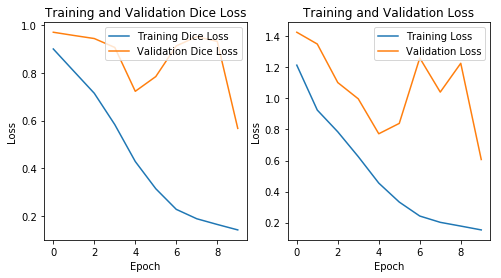

In [23]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()